In [45]:
#Dependencies
from functools import partial
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import cv
from optuna import create_study
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [46]:
X_full = pd.read_csv('/workspaces/2025SE-Mike.N-HSC-AT2/data/concrete_preprocessed.csv')
y = X_full['strength']
X = X_full.drop(['strength'], axis=1)

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cement                           904 non-null    float64
 1   blast_furnace_slag               904 non-null    float64
 2   fly_ash                          904 non-null    float64
 3   water                            904 non-null    float64
 4   superplasticizer                 904 non-null    float64
 5   coarse_aggregate                 904 non-null    float64
 6   fine_aggregate                   904 non-null    float64
 7   age                              904 non-null    float64
 8   cement_to_water_ratio            904 non-null    float64
 9   fine_aggregate_to_water_ratio    904 non-null    float64
 10  coarse_aggregate_to_water_ratio  904 non-null    float64
dtypes: float64(11)
memory usage: 77.8 KB


In [48]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 904 entries, 0 to 903
Series name: strength
Non-Null Count  Dtype  
--------------  -----  
904 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


**Model Training** \
We divide the training phase into 2 phases:
* In the 1st phase, we use Optuna to find the best tree parameters with a medium learning rate to improve trial speeds.
* In the 2nd phase, we use a small learning rate to find the best number of boosting rounds.

In [49]:
model = XGBRegressor()
train_time = 60*5 #15 minutes

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train, 
                     enable_categorical=True)
dvalid = xgb.DMatrix(data=X_val, label=y_val, 
                     enable_categorical=True)
dtest = xgb.DMatrix(data=X_test, label=y_test, 
                    enable_categorical=True)
dtrainvalid = xgb.DMatrix(data=X_train_valid, 
                          label=y_train_valid, 
                          enable_categorical=True)

# Define the callback to stop the optimization when the trial keep being pruned. 
# The number of pruned trials is defined by the threshold.
class StopWhenTrialKeepBeingPrunedCallback:
    def __init__(self, threshold: int):
        self.threshold = threshold
        self._consequtive_pruned_count = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.state == optuna.trial.TrialState.PRUNED:
            self._consequtive_pruned_count += 1
        else:
            self._consequtive_pruned_count = 0

        if self._consequtive_pruned_count >= self.threshold:
            study.stop()

# Define the objective function to optimize the hyperparameters of the XGBoost model.
def objective_GB(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse', # root mean squared error
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']), 
        'learning_rate': trial.suggest_float('learning_rate', 0.2, 0.5), # Most important parameter.
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 50, log=True), # L2 regularization
        'max_depth': trial.suggest_int('max_depth', 3, 12), # Tree depth
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 200), # Min weight of each child.
        'gamma': trial.suggest_float('gamma', 0.001, 50, log=True), # Minimum loss reduction required to make a partition
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), 
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),       
    }
    
    # integrated pruning for stopping unpromising trials.
    xgb_callback = XGBoostPruningCallback(trial, f'valid-rmse')

    model = XGBRegressor(random_state= 1, **params)
    
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=1000,
                      evals=[(dtrain, 'train'), (dvalid, 'valid')],
                      early_stopping_rounds=50,
                      verbose_eval=0,                      
                      callbacks=[xgb_callback],
                      )

    return model.best_score

# Create the study and optimize the objective function.
# Threshold is 10.
study_stop_cb = StopWhenTrialKeepBeingPrunedCallback(100)
study_gb = create_study(direction="minimize", sampler = TPESampler(seed = 42))
study_gb.optimize(objective_GB, timeout = train_time, n_trials= 3000, callbacks = [study_stop_cb])
study_gb.best_params

[I 2025-04-06 23:47:39,955] A new study created in memory with name: no-name-f486e066-0f20-46a3-9205-47cbaac7d736


[I 2025-04-06 23:47:40,957] Trial 0 finished with value: 4.287804198386965 and parameters: {'tree_method': 'hist', 'learning_rate': 0.4195981825434215, 'reg_lambda': 0.6502468545951017, 'max_depth': 4, 'min_child_weight': 32, 'gamma': 0.0018747059221802516, 'subsample': 0.9330880728874675, 'colsample_bynode': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'colsample_bylevel': 0.5102922471479012}. Best is trial 0 with value: 4.287804198386965.
[I 2025-04-06 23:47:41,404] Trial 1 finished with value: 4.58183642648733 and parameters: {'tree_method': 'approx', 'learning_rate': 0.26370173320348284, 'reg_lambda': 0.007151383480402496, 'max_depth': 4, 'min_child_weight': 61, 'gamma': 0.2922905212920093, 'subsample': 0.7159725093210578, 'colsample_bynode': 0.645614570099021, 'colsample_bytree': 0.8059264473611898, 'colsample_bylevel': 0.569746930326021}. Best is trial 0 with value: 4.287804198386965.
[I 2025-04-06 23:47:41,689] Trial 2 finished with value: 7.372522432400242 and pa

{'tree_method': 'hist',
 'learning_rate': 0.36725508975924054,
 'reg_lambda': 0.32254658418287513,
 'max_depth': 10,
 'min_child_weight': 22,
 'gamma': 0.024776407080566634,
 'subsample': 0.7717851809636164,
 'colsample_bynode': 0.9487971307487205,
 'colsample_bytree': 0.9766256641680159,
 'colsample_bylevel': 0.969728517112634}

In [50]:
base_model = XGBRegressor(random_state=1)
base_model.fit(X_train_valid, y_train_valid)
print(cross_val_score(base_model, X_train_valid, y_train_valid, scoring='neg_mean_absolute_error', cv = 5).mean())
print(r2_score(base_model.predict(X_test), y_test))

-3.3697877863079606
0.8827297936592606


In [51]:
plot_param_importances(study_gb)

In [52]:
plot_optimization_history(study_gb)

In [67]:
low_learning_rate = 0.01
params = study_gb.best_params
params['learning_rate'] = low_learning_rate
model_stage2 = xgb.train(params=params, dtrain=dtrain, 
                         num_boost_round=5000,
                         evals=[(dtrain, 'train'), (dvalid, 'valid')],
                         early_stopping_rounds=50,
                         verbose_eval=0)

Find the best number of boosting rounds.

In [68]:
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label() 
    y_pred = model.predict(dmat) 
    return mean_absolute_error(y_true, y_pred)

print('Stage 2')
print(f'best score = {score_model(model_stage2, dvalid)}')
print(f'best boosting round: {model_stage2.best_iteration}')

Stage 2
best score = 2.921933889389038
best boosting round: 1939


In [69]:
model_final = xgb.train(params=study_gb.best_params, dtrain=dtrainvalid, 
                        num_boost_round=model_stage2.best_iteration,
                        verbose_eval=0)

Evaluation of final model.

In [70]:
print('Final Model')
print(f'test score = {score_model(model_final, dtest)}')
print('Parameters')
for i, j in params.items():
    print(i, ':', j)
print(f'num_boost_round: {model_stage2.best_iteration}')

Final Model
test score = 3.158318519592285
Parameters
tree_method : hist
learning_rate : 0.01
reg_lambda : 0.32254658418287513
max_depth : 10
min_child_weight : 22
gamma : 0.024776407080566634
subsample : 0.7717851809636164
colsample_bynode : 0.9487971307487205
colsample_bytree : 0.9766256641680159
colsample_bylevel : 0.969728517112634
num_boost_round: 1939


Feature importance: By weight

In [71]:
model_final.get_score(importance_type='weight')

{'cement': 2974.0,
 'blast_furnace_slag': 1475.0,
 'fly_ash': 1162.0,
 'water': 2729.0,
 'superplasticizer': 2355.0,
 'coarse_aggregate': 2034.0,
 'fine_aggregate': 2188.0,
 'age': 2776.0,
 'cement_to_water_ratio': 2848.0,
 'fine_aggregate_to_water_ratio': 2651.0,
 'coarse_aggregate_to_water_ratio': 2336.0}

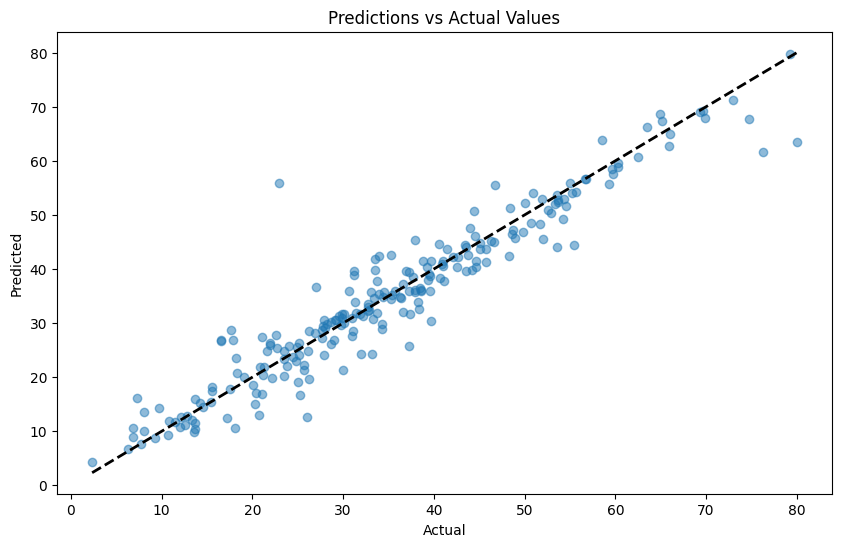

In [72]:
# Fit the model with the best parameters from the study
model = XGBRegressor(**study_gb.best_params, enable_categorical=True)
model = xgb.train(params=study_gb.best_params, dtrain=dtrainvalid, 
                        num_boost_round=model_stage2.best_iteration,
                        verbose_eval=0)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual Values')
plt.show()

In [73]:
r2_score(y_test, y_pred)

0.9104281619831043

It can be seen that the model is fitting nicely. From the coefficient of determination, 91% of variance can be explained using the model. \
This is an improvement of 3% from using a base model without hyperparameter optimization. \
Extreme overestimation/underestimation is limted.

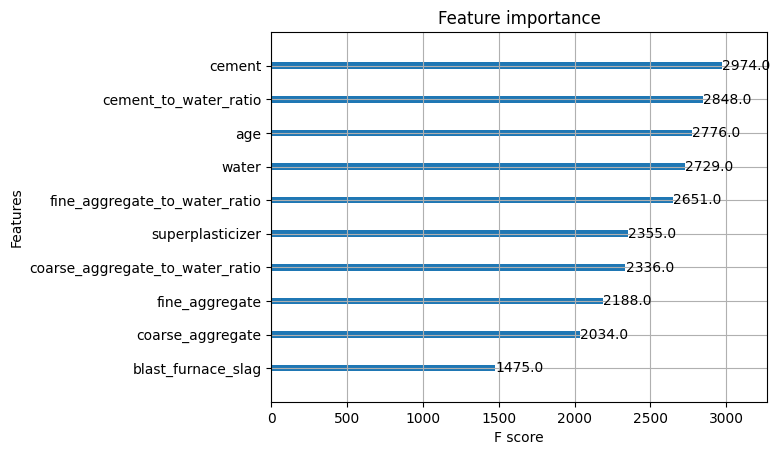

In [74]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.show()

In [75]:
cv_results = xgb.cv(params = study_gb.best_params,
        dtrain = dtest,
        num_boost_round=model_stage2.best_iteration,
        metrics = 'mape',
        seed = 42)

In [76]:
cv_results

,train-mape-mean,train-mape-std,test-mape-mean,test-mape-std
0,0.501176,0.028613,0.510299,0.039416
1,0.402986,0.019401,0.423524,0.030185
2,0.355441,0.022014,0.385337,0.028906
3,0.311064,0.024548,0.337745,0.021276
4,0.281227,0.018511,0.306841,0.019241
...,...,...,...,...
1934,0.012004,0.002300,0.213615,0.015441
1935,0.011957,0.002302,0.213733,0.015531
1936,0.011935,0.002361,0.213589,0.015502
1937,0.012022,0.002908,0.213705,0.015496


Export the model to be used in production.

In [79]:
filepath = '/workspaces/2025SE-Mike.N-HSC-AT2/model/xgboost.sav'
pickle.dump(model_final, open(filepath, 'wb'))